### Project Overview
- In a previous project we saw that the Fixed Income Market was inversely coorelated to the capital markets. We found that the capital markets could predict the 10 year treasury maturity rate with high probability. This time around  we want you to try this in reverse. Can the Fixed income market as well as the Volatility market predice the value for the S&P 500 since they are both inversely coorelate to the capital markets

### Project Approach
- Will use the 10 year treasury maturity rate, Moodys AAA coroprate bond yield as well as the VIX index as out data base for this project
- Will look at this for a 20 year period 2000- 2020
- The S&P will be our target for the equity market
- Data will be downlload for mthe FREDS website as well as imported from the pandas data reader using yahoo finance library. 

## Libraries

In [204]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import seaborn as sns
import matplotlib.pyplot as plt

### Importing 10 year corporate yield
- this data will need to be cleaned properly and converted to numeric data
- Will need to remove data not of numeric value or replace with np.nan

In [205]:
ten_year = pd.read_csv("resources/10year_treasury.csv", index_col="DATE", parse_dates = True)

In [206]:
ten_year.columns = ["rate"]

In [207]:
ten_year.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5334 entries, 2000-01-03 to 2020-06-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    5334 non-null   object
dtypes: object(1)
memory usage: 83.3+ KB


In [208]:
ten_year.replace(["."], np.nan, inplace=True)

In [209]:
ten_year = ten_year.apply(lambda x: pd.to_numeric(x))

### Analysis 
- there has been a decline in the 10 year yiels since 2000
- - Will tae a look a the daily changes for the 10year below

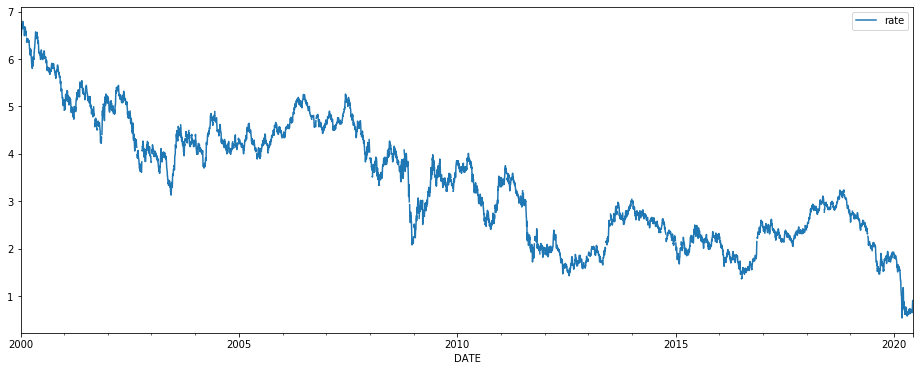

In [210]:
ten_year.plot(figsize = (16,6))

In [211]:
ten_year.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5334 entries, 2000-01-03 to 2020-06-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    5114 non-null   float64
dtypes: float64(1)
memory usage: 83.3 KB


### Moody's AAA Corporate Bond Yield

In [212]:
aaa = pd.read_csv("resources/aaayield.csv", index_col="DATE", parse_dates = True)

In [213]:
aaa.replace(["."], np.nan, inplace=True)

In [214]:
aaa = aaa.apply(lambda x: pd.to_numeric(aaa["BAMLC0A1CAAAEY"]))

In [215]:
aaa.columns = ["aaa yield"]

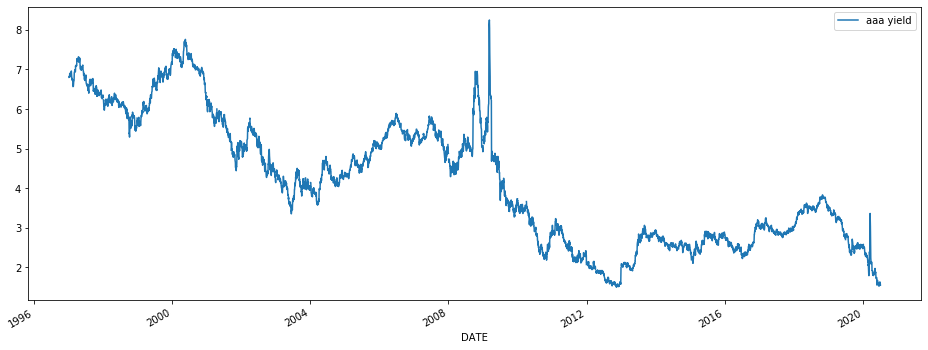

In [216]:
aaa.plot(figsize = (16,6))

### Importing Capital and Volatility Indices

In [217]:
tickers = ["^GSPC", "^VIX"]

In [218]:
dd = pd.DataFrame()

In [219]:
for t in tickers:
    dd[t] = web.DataReader(t, data_source="yahoo", start = "2000-01-01")["Open"]

In [220]:
ten_year_sliced = ten_year.loc["2000-01-03":]

In [221]:
dd_sliced = dd.loc["2000-01-03":"2020-06-11"]

In [222]:
aaa_sliced = aaa.loc["2000-01-03":"2020-06-11"]

In [223]:
working_data = pd.concat([ten_year_sliced, aaa_sliced, dd_sliced], axis=1)

In [224]:
working_data.replace([np.nan], 0.0, inplace=True)

In [225]:
working_data.corr()

,rate,aaa yield,^GSPC,^VIX
rate,1.000000,0.790266,-0.171919,0.248200
aaa yield,0.790266,1.000000,-0.296501,0.283049
^GSPC,-0.171919,-0.296501,1.000000,-0.066408
^VIX,0.248200,0.283049,-0.066408,1.000000


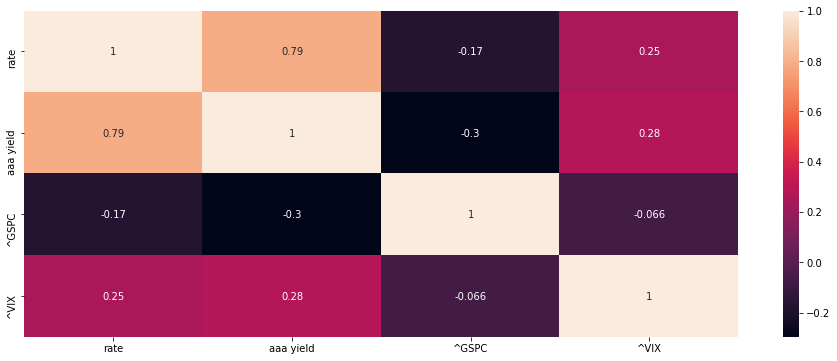

In [226]:
plt.figure(figsize=(16,6))
sns.heatmap(working_data.corr(), annot=True)

### Data prepration

In [227]:
X = working_data.drop("^GSPC", axis=1).values
y = working_data["^GSPC"].values

## Training testing and splitting

In [228]:
from sklearn.model_selection import train_test_split

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

### Scaling the data to Normal Distribution

In [230]:
from sklearn.preprocessing import MinMaxScaler

In [231]:
scalar = MinMaxScaler()

In [232]:
X_train = scalar.fit_transform(X_train)

In [233]:
X_test = scalar.transform(X_test)

### Early Stopping

In [234]:
from tensorflow.keras.callbacks import EarlyStopping

In [235]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=30)

## Model Creation 
- Will create a sequential Model with a MSE loss function

In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [237]:
model = Sequential()
model.add(Dense(units = 230, activation = "relu"))
model.add(Dense(units = 220, activation = "relu"))
model.add(Dense(units = 210, activation = "relu"))
model.add(Dense(units = 205, activation = "relu"))
model.add(Dense(units = 200, activation = "relu"))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fitting the model

In [238]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=500, callbacks=[stop])

Train on 3241 samples, validate on 2162 samples
Epoch 1/500
3241/3241 [==============================] - 3s 773us/sample - loss: 1436985.0817 - val_loss: 601721.5745
Epoch 2/500
3241/3241 [==============================] - 1s 402us/sample - loss: 478565.2504 - val_loss: 363669.8270
Epoch 3/500
3241/3241 [==============================] - 1s 357us/sample - loss: 251958.4732 - val_loss: 183776.7395
Epoch 4/500
3241/3241 [==============================] - 1s 338us/sample - loss: 146319.0500 - val_loss: 125694.4577
Epoch 5/500
3241/3241 [==============================] - 1s 365us/sample - loss: 100586.0874 - val_loss: 101327.2126
Epoch 6/500
3241/3241 [==============================] - 1s 438us/sample - loss: 79809.2004 - val_loss: 93407.8571
Epoch 7/500
3241/3241 [==============================] - 1s 340us/sample - loss: 75108.9540 - val_loss: 104620.6150
Epoch 8/500
3241/3241 [==============================] - 1s 452us/sample - loss: 71720.8114 - val_loss: 83208.1131
Epoch 9/500
3241/324

3241/3241 [==============================] - 1s 313us/sample - loss: 29325.6156 - val_loss: 39992.0892
Epoch 72/500
3241/3241 [==============================] - 1s 307us/sample - loss: 32218.5509 - val_loss: 45252.1543
Epoch 73/500
3241/3241 [==============================] - 1s 354us/sample - loss: 30099.3005 - val_loss: 42320.0634
Epoch 74/500
3241/3241 [==============================] - 1s 340us/sample - loss: 41178.0476 - val_loss: 43173.9433
Epoch 75/500
3241/3241 [==============================] - 1s 307us/sample - loss: 30156.5809 - val_loss: 42085.1740
Epoch 76/500
3241/3241 [==============================] - 1s 316us/sample - loss: 31514.1237 - val_loss: 43363.9730
Epoch 77/500
3241/3241 [==============================] - 1s 368us/sample - loss: 30901.3575 - val_loss: 41848.7999
Epoch 78/500
3241/3241 [==============================] - 1s 308us/sample - loss: 30150.2071 - val_loss: 41516.9854
Epoch 79/500
3241/3241 [==============================] - 1s 300us/sample - loss: 288

3241/3241 [==============================] - 1s 302us/sample - loss: 21933.6152 - val_loss: 34101.9613
Epoch 142/500
3241/3241 [==============================] - 1s 299us/sample - loss: 25944.7673 - val_loss: 34123.9596
Epoch 143/500
3241/3241 [==============================] - 1s 300us/sample - loss: 23805.0640 - val_loss: 34467.3639
Epoch 144/500
3241/3241 [==============================] - 1s 302us/sample - loss: 26454.3768 - val_loss: 39027.4905
Epoch 145/500
3241/3241 [==============================] - 1s 302us/sample - loss: 22660.2694 - val_loss: 41115.9074
Epoch 146/500
3241/3241 [==============================] - 1s 304us/sample - loss: 26109.6733 - val_loss: 32865.0953
Epoch 147/500
3241/3241 [==============================] - 1s 300us/sample - loss: 22775.3279 - val_loss: 34184.1950
Epoch 148/500
3241/3241 [==============================] - 1s 299us/sample - loss: 23014.5739 - val_loss: 33476.5194
Epoch 149/500
3241/3241 [==============================] - 1s 304us/sample - l

### Model Performance

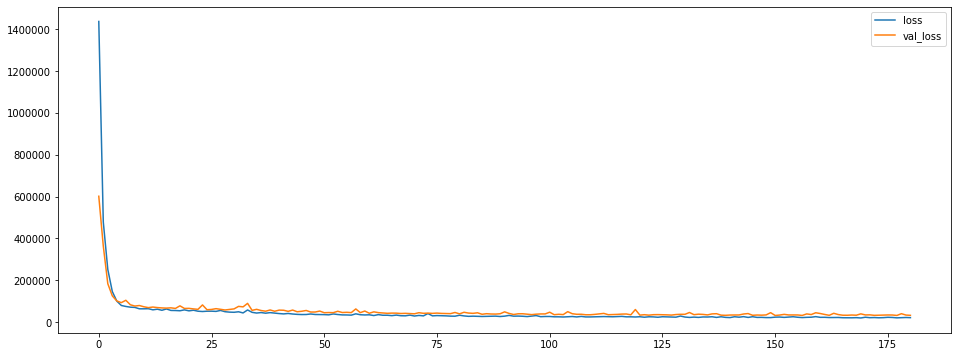

In [239]:
pd.DataFrame(model.history.history).plot(figsize = (16,6 ))

### Predicitons

In [240]:
prediction = model.predict(X_test)

### Metrics

In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [242]:
mean_absolute_error(y_test, prediction)

96.51186271192408

In [243]:
mean_squared_error(y_test, prediction)

32709.3325048624

In [244]:
explained_variance_score(y_test, prediction)

0.9333883133377265

### Testing on Random Data

In [245]:
from random import randint
random_index = randint(1, len(X_train))
random_Day = working_data.drop("^GSPC", axis = 1).iloc[random_index]

In [246]:
X_train.shape

(3241, 3)

In [247]:
new_data = scalar.transform(random_Day.values.reshape(1,3))

### Prediction the S&P Value with new data
- Model predicts the value below

In [248]:
model.predict(new_data)

array([[927.87885]], dtype=float32)

### lets check the acutal value

In [249]:
working_data.iloc[random_index]["^GSPC"]

934.8200073242188

### Conclusion
- The theory is correct the corporate interest rate produce a strong predictive capabilities of the capital Markets(^GSPC) to be specific. 

In [203]:
##model.save("resources/s&p_predicitons.csv")